In [1]:
# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense
import matplotlib.pyplot as plt
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
import random
from imutils import paths
import os
from keras.utils import to_categorical
from cnnmodel.similarvggnet import SmallerVGGNet
from keras import optimizers
from keras.preprocessing.image import img_to_array
import numpy as np
import shutil
from keras.preprocessing.image import ImageDataGenerator
import cv2

from sklearn.model_selection import train_test_split

%matplotlib inline

Using TensorFlow backend.


In [2]:
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('DatasetN')))
random.seed(42)
random.shuffle(imagePaths)
print(len(imagePaths))

[INFO] loading images...
6532


In [3]:
EPOCHS = 500
INIT_LR = 1e-4
BS = 128
w=130 #you can change this in a multiple of 2
h=86

# initialize the data and labels
data = []
labels = []

In [4]:
Emotions = [(0,'Angry'),(1,'Disgusted'),(2,'Fear'),(3,'Sad'),(4,'Happy'),(5,'Neutral'),(6,'Surprised')]

In [5]:
i = 0
for imagePath in imagePaths:
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio
#     b, g, r = cv2.split(image)
#     cv2.imshow('imgage',g)
#     cv2.waitkey(0)
#     key = cv2.waitKey()
#     cv2.destroyAllWindows()
    g = image
    image = img_to_array(g)
    data.append(image)
    name = imagePath.split(os.path.sep)[1]
    if name == Emotions[0][1]:
        label = Emotions[0][0]
    elif name == Emotions[1][1]:
        label = Emotions[1][0]
    elif name == Emotions[2][1]:
        label = Emotions[2][0]
    elif name == Emotions[3][1]:
        label = Emotions[3][0]
    elif name == Emotions[4][1]:
        label = Emotions[4][0]
    elif name == Emotions[5][1]:
        label = Emotions[5][0]
    elif name == Emotions[6][1]:
        label = Emotions[6][0]
    labels.append(label)

# scale the raw pixel intensities to the range [0, 1]
data = np.array(data, dtype="float") / 255.0
labels = np.array(labels)

6
4
5
1


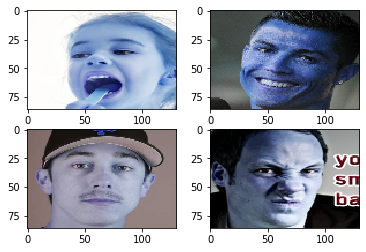

In [6]:
for i in range(0, 4):
        plt.subplot(220 + 1 + i)
        plt.imshow(data[i+10])
        print(labels[i+10])

In [7]:
labels[:20]

array([4, 0, 4, 5, 1, 5, 4, 0, 2, 6, 6, 4, 5, 1, 6, 0, 5, 6, 2, 3])

In [8]:
(trainX, testX, trainY, testY) = train_test_split(data, labels, test_size=0.25, random_state=42)

In [9]:
trainY = to_categorical(trainY, num_classes=7)
testY = to_categorical(testY, num_classes=7)

In [10]:
len(trainX),len(trainY),len(testX),len(testY)

(4899, 4899, 1633, 1633)

In [10]:
# trainX = [trainX]

In [10]:
trainY[0].shape

(7,)

In [11]:
aug = ImageDataGenerator(zca_whitening=True,fill_mode="nearest")

/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:336: UserWarning: This ImageDataGenerator specifies `zca_whitening`, which overrides setting of `featurewise_center`.
  warnings.warn('This ImageDataGenerator specifies '


/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:716: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/keras_preprocessing/image/image_data_generator.py:735: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


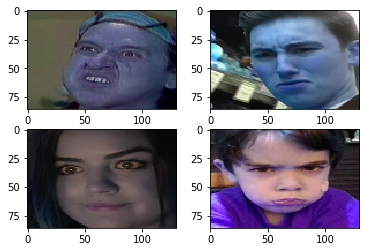

In [12]:
#Checking if a folder already exists. If not create a new one.
if os.path.exists('AugmentedImages'):
    shutil.rmtree('AugmentedImages')
os.mkdir('AugmentedImages')

#Saving and displaying augmented images
for X_batch, y_batch in aug.flow(trainX, trainY, batch_size=len(trainX)):
    # create a grid of 2x2 images
    for i in range(0, 4):
        plt.subplot(220 + 1 + i)
        plt.imshow(X_batch[i])
    # show the plot
    plt.show()
    break

In [31]:
# from keras.preprocessing.image import ImageDataGenerator

# train_datagen = ImageDataGenerator(rescale = 1./255,
#                                    shear_range = 0.2,
#                                    zoom_range = 0.2,
#                                    horizontal_flip = True)

# test_datagen = ImageDataGenerator(rescale = 1./255)

# training_set = train_datagen.flow_from_directory('Dataset/training_set',
#                                                  target_size = (64, 64),
#                                                  batch_size = 32,
#                                                  class_mode = 'binary')

# test_set = test_datagen.flow_from_directory('Dataset/test_set',
#                                             target_size = (64, 64),
#                                             batch_size = 32,
#                                             class_mode = 'binary')

In [32]:
# for X_batch, y_batch in train_datagen.flow_from_directory('Dataset/training_set', batch_size=50, save_format='png'):
#     # create a grid of 2x2 images
#     for i in range(0, 4):
#         plt.subplot(220 + 1 + i)
#         plt.imshow(X_batch[i], cmap=plt.get_cmap('gray'))
#     # show the plot
#     plt.show()
#     break

In [13]:
BS = 32

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution and Pooling
classifier.add(Convolution2D(16, 3, 3, input_shape = (h, w, 3), activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer and pooling layer
classifier.add(Convolution2D(64, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(output_dim = 64, activation = 'relu'))
classifier.add(Dropout(0.1))

classifier.add(Dense(output_dim = 7, activation = 'softmax'))

es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
print(classifier.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:7: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(16, (3, 3), input_shape=(86, 130, ..., activation="relu")`
  import sys
/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), activation="relu")`
  # This is added back by InteractiveShellApp.init_path()
/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=64)`
/home/tazer/anaconda3/envs/tf/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="softmax", units=7)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 84, 128, 16)       448       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 42, 64, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 40, 62, 64)        9280      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 20, 31, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 39680)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2539584   
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
__________

In [14]:
H = classifier.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
    validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
    epochs=EPOCHS, verbose=1, callbacks=[es]) 

Instructions for updating:
Use tf.cast instead.
Epoch 1/500
153/153 [==============================] - 59s 384ms/step - loss: 0.4115 - acc: 0.8562 - val_loss: 0.4000 - val_acc: 0.8574
Epoch 2/500
153/153 [==============================] - 57s 371ms/step - loss: 0.3820 - acc: 0.8589 - val_loss: 0.3906 - val_acc: 0.8583
Epoch 3/500
153/153 [==============================] - 57s 372ms/step - loss: 0.3391 - acc: 0.8678 - val_loss: 0.3954 - val_acc: 0.8549
Epoch 4/500
153/153 [==============================] - 57s 373ms/step - loss: 0.2819 - acc: 0.8891 - val_loss: 0.4157 - val_acc: 0.8479
Epoch 00004: early stopping


In [19]:
classifier.save('model.h5')

In [26]:
image = cv2.imread('test3.jpeg')
orig = image.copy()
image = cv2.resize(image, (w,h))#resize image maintaining aspect ratio

In [27]:
#image = cv2.resize(image, (28, 28))
image = image.astype("float") / 255.0
image = img_to_array(image)
image = np.expand_dims(image, axis=0)

In [28]:
arr = classifier.predict(image)[0]
print(arr)

[0.00978253 0.0450317  0.17184427 0.06576331 0.06204422 0.03295545
 0.6125785 ]


In [ ]:

res = np.amax(arr)
cat[np.where(arr == res)[0][0]]

## VGGNET

In [13]:
print("[INFO] compiling model...")
model = SmallerVGGNet.build(width=w, height=h, depth=3, classes=7)

sgd = optimizers.SGD(lr=0.0005, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='binary_crossentropy', optimizer= sgd, metrics=['accuracy'])


#opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
#model.compile(loss="binary_crossentropy", optimizer=opt,
#	metrics=["accuracy"])
print(model.summary())

[INFO] compiling model...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 86, 130, 32)       896       
_________________________________________________________________
activation_1 (Activation)    (None, 86, 130, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 86, 130, 32)       128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 86, 130, 32)       9248      
_________________________________________________________________
activation_2 (Activation)    (None, 86, 130, 32)       0         
_____________________________________________________________

In [ ]:
BS = 64
print("[INFO] training network...")
# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)

H = model.fit_generator(aug.flow(trainX, trainY, batch_size=BS),
	validation_data=(testX, testY), steps_per_epoch=len(trainX) // BS,
	epochs=EPOCHS, verbose=1, callbacks=[es])

# save the model to disk
print("[INFO] serializing network...")

[INFO] training network...
Instructions for updating:
Use tf.cast instead.
Epoch 1/500


In [ ]:
# save the model to disk
print("[INFO] serializing network...")
model.save('VGGModel.h5')

In [22]:
EPOCHS = len(H.history['loss'])
p = len(test_set) #Number of test sets
pred = []
for a in classifier.predict(test_set):
    if a[1]>a[0]:
        pred.append(1)
    else:
        pred.append(0)
score  = model.evaluate(testX,testY)[1]
z = 1.96 * sqrt( (score * (1 - score)) / p)
print('Accuracy:',round(score,2),'+/-',round(z,2))

AttributeError: 'DirectoryIterator' object has no attribute 'ndim'